# Forecasting the Realized Volatiliy
Realized volatility is a financial term used to describe the actual level of volatility experienced by a financial asset over a specific period of time. Volatility is a measure of the degree of variation in the price of an asset over time. Realized volatility is calculated by measuring the variation of an asset's price over a set period, which can range from daily to intra-day.

In options trading, the volatility of the underlying asset is a key factor in determining the price of an option. A more accurate prediction of realized volatility can lead to more informed investment decisions.

To predict realized volatility, the ARCH model variations and deep learning models such as LSTM (Long Short-Term Memory), RNN (Recurrent Neural Network), and GRU (Gated Recurrent Unit) are being used in this notebook.

## Table of Content

#### 1. Importing the Libraries
#### 2. Analysis of Underlying asset Returns
#### 3. ARCH Variations
    - 3.1. ARCH Model

## 1. Importing the Libraries

In [56]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
from math import *
from scipy.stats import jarque_bera
from scipy.stats import normaltest
warnings.filterwarnings('ignore')

## 2. Analysis of Underlying asset  returns

In [57]:
# Download the stock price data
stocks = 'AAPL' # Underlying asset's ticker
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 3, 30)
df = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [58]:
# Checking the data
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565699,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873640,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875893,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210678,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140903,237458000


In [59]:
# Explanatory data analysis
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2074.000000,2074.000000,2074.000000,2074.000000,2074.000000,2.074000e+03
mean,75.119906,75.990459,74.292357,75.178168,73.472919,1.299627e+08
std,49.810314,50.482314,49.172684,49.855927,50.357628,6.776708e+07
min,22.500000,22.917500,22.367500,22.584999,20.883036,3.519590e+07
25%,32.690001,32.996249,32.474998,32.651875,29.865811,8.446092e+07
50%,49.725000,50.112499,49.332500,49.783749,48.221861,1.107118e+08
75%,127.809999,128.826248,126.115002,127.339998,126.088297,1.544310e+08
max,182.630005,182.940002,179.119995,182.009995,180.683868,6.488252e+08


In [60]:
# Calculate the returns of the price
df['return'] = df['Adj Close'].apply(lambda x: log(x)) - df['Adj Close'].shift(1).apply(lambda x: log(x))
df['return'] = df['return']*100

In [61]:
# Drop the null values and checking the dataframe
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873640,257142000,-2.857618
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875893,263188400,0.009435
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210678,160423600,1.392451
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140903,237458000,3.770236
2015-01-09,28.167500,28.312500,27.552500,28.002501,25.167875,214798000,0.107225


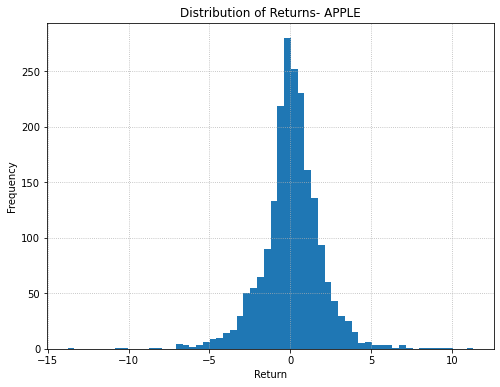

In [62]:
# Plotting the returns
plt.figure(figsize=(8, 6))
plt.hist(df['return'], bins=60)
plt.title('Distribution of Returns- APPLE')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.grid(linestyle=':');

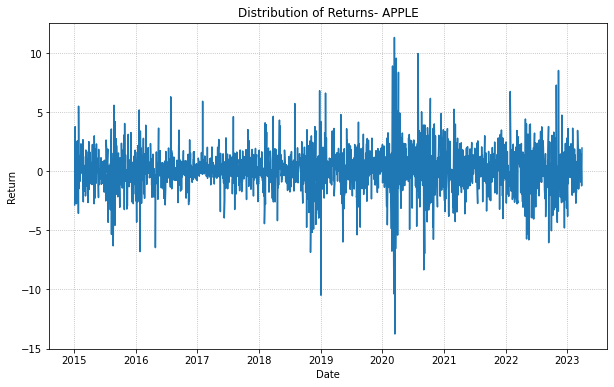

In [63]:
# Plotting the returns with respect to time
plt.figure(figsize=(10, 6))
plt.plot(df['return'])
plt.title('Returns- APPLE')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(linestyle=':');

In [64]:
# Testing the normal distribution of the returns
skewness = np.mean(df['return'] - np.mean(df['return'])) / np.std(df['return'])
kurtosis = np.mean((df['return'] - np.mean(df['return'])) ** 4) / np.mean((df['return'] - np.mean(df['return']))**2)**2 - 3
jb_test = jarque_bera(df['return'])
p_value = jb_test[1]
norm_test = normaltest(df['return'])
p_value = norm_test[1]
print('Jarque-Bera test p-value: ', jb_test[1])
print('Normality test p-value: ', norm_test[1])

Jarque-Bera test p-value:  0.0
Normality test p-value:  8.352427086516682e-57


In [65]:
# Calculating the realized volatility and dropping NA values and unnecessary columns
df['realized_vol'] = df['return'].rolling(5).std()*sqrt(5) # 5-days realized volatility
df.drop(columns=['Open', 'High', 'Low', 'Close'], inplace=True)
df.dropna(inplace=True)

In [66]:
# Checking the data
df.tail()

,Adj Close,Volume,return,realized_vol
Date,,,,
2023-03-23,158.929993,67622100,0.694529,2.403773
2023-03-24,160.250000,59196500,0.827129,2.107840
2023-03-27,158.279999,52390300,-1.236949,2.469941
2023-03-28,157.649994,45992200,-0.398826,2.085766
2023-03-29,160.770004,51305700,1.959745,2.742022


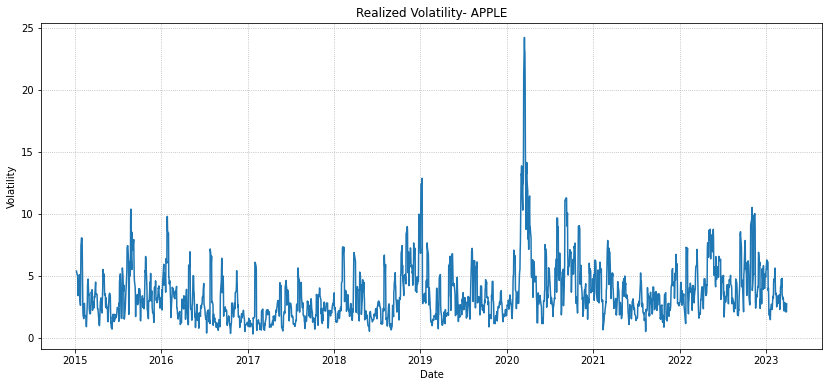

In [67]:
# Plotting the realized volatility
plt.figure(figsize=(14, 6))
plt.plot(df['realized_vol'])
plt.title('Realized Volatility- APPLE')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(linestyle=':');

## 3. ARCH Variations

### 3.1. ARCH Model
The ARCH (Autoregressive Conditional Heteroscedasticity) model is a statistical model commonly used in finance to model time-varying volatility in asset prices. The model assumes that the variance of an asset's returns is not constant over time, but rather varies based on past returns.

The ARCH model is based on the idea that volatility clusters, meaning that periods of high volatility tend to be followed by further periods of high volatility, and periods of low volatility tend to be followed by further periods of low volatility. The model uses past observations of asset returns to estimate the variance of returns in the future.

The basic ARCH model is a univariate time series model that assumes that the conditional variance of an asset's returns at time t is a function of the variance of past returns. 

In [68]:
# Defining the split and assigning the split data
n = 252
split_date = df['return'].iloc[-n:].index
split_date

DatetimeIndex(['2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01',
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11',
               ...
               '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27',
               '2023-03-28', '2023-03-29'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

In [69]:
# Built-in function for ARCH modelling
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4170.15
Distribution:                  Normal   AIC:                           8344.30
Method:            Maximum Likelihood   BIC:                           8355.57
                                        No. Observations:                 2069
Date:                Sun, Apr 09 2023   Df Residuals:                     2069
Time:                        14:28:43   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.7346      0.193     14.182  1.189e-45 [  2.357,  3.11

In [70]:
# Tuning the ARCH model with respect to lag parameter
bic_arch = []
for p in range(1, 22): 
    arch = arch_model(df['return'], mean='zero', vol='ARCH', p=p)\
             .fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch): 
        best_param = p
best_param # Extracting the best number of lags

8

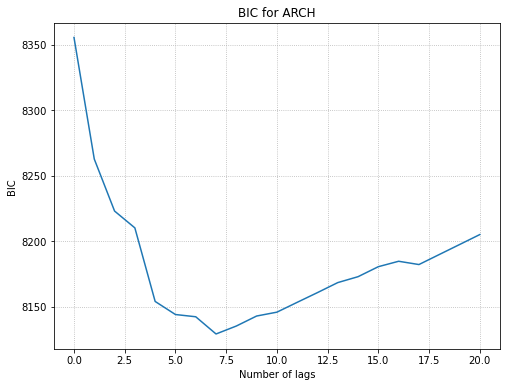

In [71]:
# Plotting the Bayesian Information Criterion for the ARCH model w.r.t. lag
plt.figure(figsize=(8, 6))
plt.plot(bic_arch)
plt.title('BIC for ARCH')
plt.ylabel('BIC')
plt.xlabel('Number of lags')
plt.grid(linestyle=':');

In [72]:
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=best_param)\
                 .fit(disp='off') # Building the model based on the best lag
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4030.24
Distribution:                  Normal   AIC:                           8078.47
Method:            Maximum Likelihood   BIC:                           8129.19
                                        No. Observations:                 2069
Date:                Sun, Apr 09 2023   Df Residuals:                     2069
Time:                        14:28:46   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1198      0.180      6.232  4.597e-10 

In [73]:
# Forecast performance measurements
forecast = arch.forecast(start=split_date[0]) # Forecasting based on ARCH
forecast_arch = forecast
rmse_arch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                     np.sqrt(forecast_arch\
                     .variance.iloc[-len(split_date):]/100))) # Testing the accuracy of the ARCH model
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1626


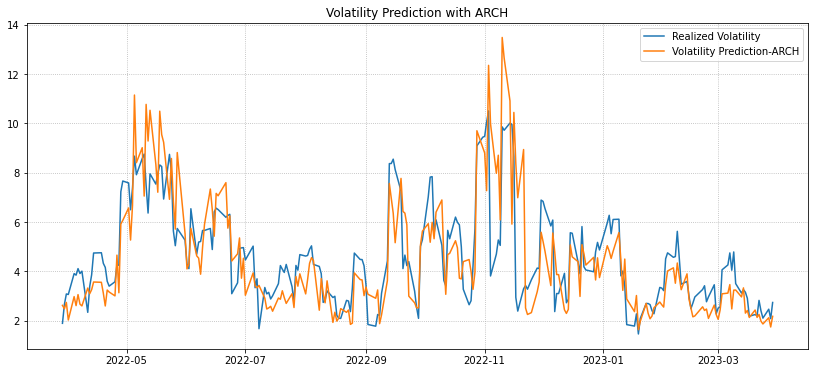

In [74]:
plt.figure(figsize=(14, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):],
      label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.grid(linestyle=':');

In [100]:
# Calculate the number of steps that the direction of the movement was the same as the direction of the prediction
df_forecast = pd.concat([forecast_arch.variance.iloc[-len(split_date):],df['realized_vol'].iloc[-len(split_date):]],axis=1)
df_forecast['real_vol_lag'] = df_forecast['realized_vol'].shift(1) # One lag of the realized volatility
df_forecast['real_vol_diff'] = df_forecast['realized_vol'].diff(1) # Difference between realized vol. and its lag
df_forecast['rv_h.1_diff'] = df_forecast['h.1'] - df_forecast['real_vol_lag'] # Difference between prediction and actual val
df_forecast['sign'] = df_forecast['real_vol_diff'] * df_forecast['rv_h.1_diff'] # Determining the sign of the direction
df_forecast['sign'] = (df_forecast['sign'] > 0).astype(int) # If sign>0, the directions were the same
df_forecast.head(10)

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff,sign
Date,,,,,,
2022-03-29,2.625159,1.897393,NaN,NaN,NaN,0
2022-03-30,2.486803,2.664650,1.897393,0.767257,0.589410,1
2022-03-31,2.744367,3.087585,2.664650,0.422934,0.079717,1
2022-04-01,2.032231,3.067030,3.087585,-0.020555,-1.055354,1
2022-04-04,2.979717,3.913563,3.067030,0.846533,-0.087313,0
2022-04-05,2.614835,3.850545,3.913563,-0.063018,-1.298728,1
2022-04-06,3.061305,4.114827,3.850545,0.264282,-0.789240,0
2022-04-07,2.673827,3.915522,4.114827,-0.199305,-1.440999,1
2022-04-08,2.602884,4.011776,3.915522,0.096254,-1.312638,0


In [81]:
# Number of steps that the signs were the same and opposite (1:= The same direction of prediction and actual value)
df_forecast['sign'].value_counts(normalize=False)

1    157
0     94
Name: sign, dtype: int64

In [99]:
"""The sum of the absolute values of the 'real_vol_diff' column is the amount of Profit/Loss that we will have after
each prediction. If the value of the 'sign' is equal to 1, it means that the direction of the prediction and the movement
is the same, thus, we will have a profit as much as the actual movement in the value of the Implied Volatility.
On the other hand, if the 'sign' is equal to 0, it means that the direction of the prediction and the actual movement are
opposite, thus, we will have a loss as much as the actual movement in the value of the Implied Volatility."""
df_forecast.abs().groupby('sign').sum() 

,h.1,realized_vol,real_vol_lag,real_vol_diff,rv_h.1_diff
sign,,,,,
0,438.663937,471.425116,455.984999,36.666214,68.260671
1,678.523669,684.850441,697.548535,147.938776,197.599176


### 3.2. GARCH Model
GARCH (Generalized Autoregressive Conditional Heteroscedasticity) is a statistical model used in finance to model the volatility of asset prices over time. It is an extension of the ARCH model.

The GARCH model is similar to the ARCH model in that it assumes that the conditional variance of an asset's returns is not constant over time, but varies based on past returns. However, the GARCH model allows for a more flexible specification of the variance dynamics by including lagged values of both the squared error term and the conditional variance term in the model equation.